# Merge CUES and GOES datasets

Read in our CUES and GOES datasets, set up the time bounds we want to look at, and resample everything to 5 minute intervals.

Then merge the GOES brightness temperature observations with the CUES dataset, and output the merged dataset for analysis elsewhere.

In [3]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import xarray as xr
import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
#### Open CUES data file:

In [5]:
cues_ds = pd.read_pickle('data/CUES_L1_Temp_Rad_Snowdepth_2017-2020_lw.pkl')
cues_ds = cues_ds.to_xarray()

#### Open GOES L1b Radiance observations for the CUES site:
Convert times to UTC-8

In [6]:
# Find all our GOES files
directory = '/storage/GOES/pkl/CUES'
goes_files = getListOfFiles(directory)
# Read in the files with pandas
goes = []
_ = [goes.append(pd.read_pickle(i)) for i in goes_files]
goes = pd.concat(goes)
# Change GOES time values from UTC to UTC-8 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC'})
goes['datetime'] = goes['timeUTC'] - pd.Timedelta(hours=8)
goes = goes.drop(columns=['timeUTC'])
# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('datetime')
_goes.sort_index(inplace=True)
_goes = _goes.loc[~_goes.index.duplicated(keep='first')] # there are duplicates somewhere in the GOES data, remove them
_goes = _goes.loc[_goes.index >= pd.datetime(2017,2,28)]# there's also some values before 2017, remove them
goes_ds = _goes.to_xarray()

Find non-orthorectified GOES L1b Radiance observations for comparison:

In [7]:
# Find all our GOES files
directory = '/storage/GOES/pkl/CUES_not_orthorectified'
goes_files = getListOfFiles(directory)
# Read in the files with pandas
goes = []
_ = [goes.append(pd.read_csv(i)) for i in goes_files]
goes = pd.concat(goes)
# Set data type for timstamp
goes['time'] = pd.to_datetime(goes['time'])
# Change GOES time values from UTC to UTC-8 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC', 'Rad': 'Rad_not_orthorectified', 'ref_or_tb': 'tb_not_orthorectified'})
goes['datetime'] = goes['timeUTC'] - pd.Timedelta(hours=8)
goes = goes.drop(columns=['timeUTC'])
# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('datetime')
_goes.sort_index(inplace=True)
_goes = _goes.loc[~_goes.index.duplicated(keep='first')] # there are duplicates somewhere in the GOES data, remove them
_goes = _goes.loc[_goes.index >= pd.datetime(2017,2,28)]# there's also some values before 2017, remove them
goes_not_orthorectified_ds = _goes.to_xarray()

#### Open GOES L2 ABI Cloud Mask observations for the CUES site:
Convert times to UTC-8

In [8]:
## Find all our GOES-16 ABI Cloud Mask timeseries files
#directory = '/home/spestana/git/goes-ortho/GOES-16_ABI-L2_timeseries/ACMC/CUES/*.csv'
#goes_files = glob.glob(directory)
## open all csv files and concatinate together
#goes_df = pd.concat([pd.read_csv(file) for file in goes_files], ignore_index=True)
## set time column to a timestamp datatype
#goes_df['time'] = [pd.Timestamp(t) for t in goes_df.time]
## sort by the time column
#goes_df.sort_values(by='time', inplace=True)
### Change GOES time values from UTC to UTC-8 for CUES site:
#goes_df = goes_df.rename(columns={'time': 'timeUTC'})
#goes_df['datetime'] = goes_df['timeUTC'] - pd.Timedelta(hours=8)
#goes_df = goes_df.drop(columns=['timeUTC'])
### Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
#_goes_df = goes_df.set_index('datetime')
#_goes_df.sort_index(inplace=True)
## save out to a pickle file
##_goes_df.to_pickle('data/GOES-16_ABI-L2-ACMC_CUES_2017-2020.pkl')
### convert to xarray
#goes_acm = _goes_df.to_xarray()

---
#### Set time bounds and resample

Select only the overlapping time period we want, ~~and resample all of these to 5 minute means, ignoring any nan values.~~

Select only the CUES data (1 minute obs) closest in time to each ABI image (5 minute obs).

(CUES provides ~1-minute observations, GOES is 5- ~~or 10-~~ minute)

In [13]:
#startdate = '2017-03-01'
startdate = '2017-04-19'
enddate = '2020-06-30'

#cues_ds_5min = cues_ds.sel(datetime=slice(startdate, enddate))
#_goes_ds_5min = goes_ds.sel(datetime=slice(startdate, enddate))#.sel(datetime=cues_ds_5min.datetime, method='nearest')
#_goes_not_orthorectified_ds_5min = goes_not_orthorectified_ds.sel(datetime=slice(startdate, enddate)).sel(datetime=_goes_ds_5min.datetime, method='nearest')
#cues_ds_5min = cues_ds.sel(datetime=slice(startdate, enddate)).sel(datetime=_goes_ds_5min.datetime, method='nearest')
# try interpolating to grab the nearest 5minute value
#cues_ds_5min = cues_ds.sel(datetime=slice(startdate, enddate)).interpolate_na('datetime', method='linear', limit=5).sel(datetime=_goes_ds_5min.datetime, method='nearest')

cues_ds_5min = cues_ds.sel(datetime=slice(startdate, enddate)).resample(datetime='5min').reduce(np.nanmean)
_goes_ds_5min = goes_ds.sel(datetime=slice(startdate, enddate)).resample(datetime='5min').reduce(np.nanmean)
_goes_not_orthorectified_ds_5min = goes_not_orthorectified_ds.sel(datetime=slice(startdate, enddate)).resample(datetime='5min').reduce(np.nanmean)
#goes_acm_5min = goes_acm.sel(datetime=slice(startdate, enddate)).resample(datetime='5min').reduce(np.nanmean)

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/core/variable.py:1462: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,5))
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(linestyle='none', marker='.', label='CUES Tss 1-minute')
_goes_ds_5min.tb.plot(linestyle='none', marker='o', label='GOES Tb_C')
cues_ds_5min['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(linestyle='none', marker='s', c='r', markersize=10, alpha=0.5,  label='CUES Tss 5-minute nearest')
plt.xlim((pd.Timestamp('2018-04-10T11'),pd.Timestamp('2018-04-10T12')))
plt.legend()

#### Merge the datasets

Merge GOES brightness temperature into the CUES dataset

In [12]:
# Find nearest GOES Tb observation given a CUES datetime
_goes_ds = _goes_ds_5min.sel(datetime=cues_ds_5min.datetime)
_goes_not_orthorectified_ds = _goes_not_orthorectified_ds_5min.sel(datetime=cues_ds_5min.datetime)
#_goes_acm = goes_acm_5min.sel(datetime=cues_ds_5min.datetime)

# assign value to new column in cues dataset
cues_ds_5min['goes_tb_c'] = (['datetime'],  _goes_ds.tb)
#cues_ds_5min['goes_rad'] = (['datetime'],  _goes_ds.Rad)
cues_ds_5min['goes_tb_not_orthorectified_c'] = (['datetime'],  _goes_not_orthorectified_ds.tb_not_orthorectified - 273.15)
#cues_ds_5min['goes_rad_not_orthorectified'] = (['datetime'],  _goes_not_orthorectified_ds.Rad_not_orthorectified)
#cues_ds_5min['goes_bcm'] = (['datetime'],  _goes_acm.BCM)
#cues_ds_5min['goes_bcm_dqf'] = (['datetime'],  _goes_acm.DQF)

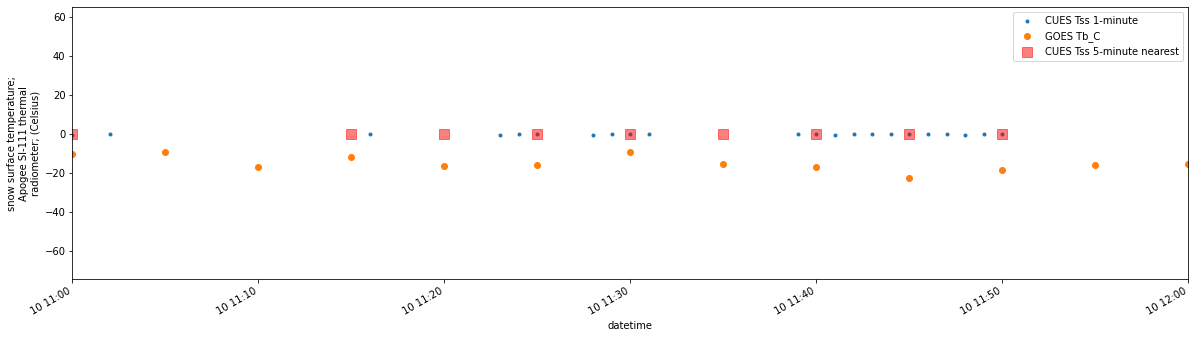

In [13]:
plt.figure(figsize=(20,5))
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(linestyle='none', marker='.', label='CUES Tss 1-minute')
cues_ds_5min.goes_tb_c.plot(linestyle='none', marker='o', label='GOES Tb_C')
cues_ds_5min['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(linestyle='none', marker='s', c='r', alpha=0.5, markersize=10, label='CUES Tss 5-minute nearest')
plt.xlim((pd.Timestamp('2018-04-10T11'),pd.Timestamp('2018-04-10T12')))
plt.legend()

**Additional data cleanup steps:**

Compute daily median snow depth:

* To remove "spikes" that show up in the original data, take the difference between each adjacent 5-minute timestep, then take the absolute value of this difference. **Ignore any snowdepth values where that difference (change in snow depth) is > 1 cm in 5 minutes.**

* **Then resample to the daily median of the remaining depth values**. 

* There are still a few erroneous large daily snowdepth values, so finally **filter out depths > 570 cm** since those are larger than any other values in the timeseries. 

* Replace all NaN values with linearly interpolated values. 

* Finally add our cleaned up daily median snow depths to the original dataset.

In [14]:
print(len(cues_ds_5min.datetime))
print(len(np.unique(cues_ds_5min.datetime)))

336384
336384


In [15]:
# compute the difference between each timestep, take the absolute value of this difference
deltas = np.abs(cues_ds_5min['snow depth  remote boom;  ultrasonic depth pinger on remote boom; (cm)'].diff('datetime',1))
# ignore any snowdepth values where the change is > 1 cm in 5 minutes
depths_adj = cues_ds_5min['snow depth  remote boom;  ultrasonic depth pinger on remote boom; (cm)'].where(deltas<1)
# resample to daily and compute median
daily_median_snow_depth = depths_adj.resample(datetime="1D").median()
# rename this DataArray
daily_median_snow_depth = daily_median_snow_depth.rename('daily_median_snow_depth')
# fill nan values by day (I have to go back to a pandas Dataframe here)
daily_median_snow_depth = daily_median_snow_depth.to_dataframe().loc[cues_ds_5min.to_dataframe().index].fillna(method='bfill')
# remove depths that are larger than the maximum in the whole 2017-2020 data record I've identified (570 cm)
max_daily_median_snowdepth = 570
daily_median_snow_depth = daily_median_snow_depth.where(daily_median_snow_depth<max_daily_median_snowdepth)
# convert back into an xarray (Dataset)
daily_median_snow_depth = daily_median_snow_depth.to_xarray()
# interpolate to fill missing values
daily_median_snow_depth = daily_median_snow_depth.interpolate_na('datetime', method='linear')
# finally pull out the values we want, put back into the original dataset as a new variable
cues_ds_5min['daily_median_snow_depth'] = (['datetime'], daily_median_snow_depth.daily_median_snow_depth)

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


Plot the old snow depth and new daily median snow depth:

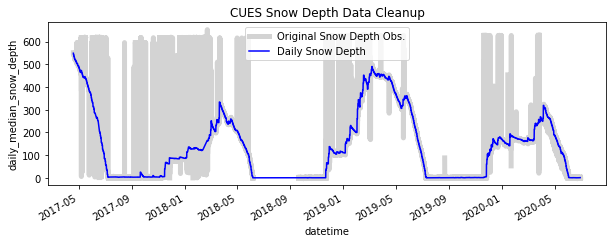

In [16]:
plt.figure(figsize=(10,3))
cues_ds_5min['snow depth  remote boom;  ultrasonic depth pinger on remote boom; (cm)'].plot(linewidth=5, color='lightgrey', label='Original Snow Depth Obs.')
cues_ds_5min.daily_median_snow_depth.plot(color='b',label='Daily Snow Depth')
plt.title('CUES Snow Depth Data Cleanup')
plt.legend();

**Fix the binary "cloud_flag" field:**
* When I took the 5-minute mean values, this binary field gained some decimal values for 5-minute periods where cloud cover was variable (some mean value between 0 and 1), set all of these non-zero fields back to 1.

In [17]:
cues_ds_5min['cloud_flag'][cues_ds_5min.cloud_flag != 0] = 1

**Fix the binary CUES sun flag field.**
* Like the "cloud_flag", when I took the 5-minute means, time periods with 0s and 1s ended up with values between 0 and 1
* Set all values <1 (partial sun) back to 0 (assume no sun in these 5 minutes)

In [18]:
# make a copy
cues_ds_5min['sun_flag'] = cues_ds_5min['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']
# set values back to binary on this copy
cues_ds_5min.sun_flag[cues_ds_5min['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] != 1] = 0

**Compute difference between GOES Tb and CUES Tss**

(GOES Tb - CUES Tss) and add it to the dataset

In [19]:
# Orthorectified GOES
cues_ds_5min['goes_cues_diff'] = cues_ds_5min.goes_tb_c - cues_ds_5min['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']

# Not orthorecitfied, original GOES
cues_ds_5min['goes_cues_diff_not_orthorectified'] = cues_ds_5min.goes_tb_not_orthorectified_c - cues_ds_5min['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']

**Open the 5-minute GOES-16 ABI Cloud Mask product:**

In [23]:
goes_cloudmask = pd.read_pickle('data/GOES-16_ABI-L2-ACMC_CUES_2017-2020.pkl')
goes_cloudmask = goes_cloudmask.to_xarray()
# the cloudmask timeseries is already in UTC-8

Round the ABI Cloud Mask timestamps to the nearest minute to match these up with the merged GOES and CUES (5-minute interval) data. Add the cloud mask to the cues_ds (**NOTE**: I have only a shorter time period covered by the cloud mask than the rest of the GOES and CUES data)

In [24]:
goes_cloudmask['datetime'] = goes_cloudmask.datetime.dt.floor('5min')
cues_ds_5min['ABI_Cloud_Mask'] = goes_cloudmask.BCM

Rename the "datetime" index column to just "time" and add an hour of day and month and week field

In [25]:
cues_ds_5min = cues_ds_5min.rename({'datetime': 'time'})

# create hour of day field
cues_ds_5min['hour_of_day'] = cues_ds_5min.time.dt.hour

# create month field
cues_ds_5min['month'] = cues_ds_5min.time.dt.month

# create week field
cues_ds_5min['week'] = cues_ds_5min.time.dt.week

#### Export this merged dataset

In [26]:
cues_ds_5min.to_dataframe().to_pickle('data/goes-cues_2017-2020_v2.pkl')